In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import ast
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import statsmodels.formula.api as smf
from helpers import *

# Data loading

In [2]:
df = pd.read_csv('data/movie_features_v5.csv')

In [3]:
display(df.head())

,movie_id,title,budget,revenue,release_date,runtime,original_language,genres,production_countries,spoken_languages,...,average_actor_exp,min_actor_exp,max_actor_exp,multiplier,year,year_group,category,title_word_count,release_quarter,spoken_languages_count
0,507089.0,Five Nights at Freddy's,20000000.0,271900000.0,2023-10-25,110.0,en,"['Horror', 'Mystery']",['United States of America'],['English'],...,5.600000,0.0,14.0,13.595000,2023,2020,low,4,4,1
1,951491.0,Saw X,13000000.0,100900000.0,2023-09-26,118.0,en,"['Horror', 'Thriller']",['United States of America'],"['Norsk', 'Español', 'English']",...,5.857143,0.0,11.0,7.761538,2023,2020,low,2,3,3
2,762430.0,Retribution,20000000.0,16700000.0,2023-08-23,91.0,en,"['Action', 'Thriller', 'Crime']","['France', 'Germany', 'United States of America']","['Deutsch', 'English']",...,9.142857,0.0,41.0,0.835000,2023,2020,low,1,3,2
3,678512.0,Sound of Freedom,14500000.0,247800000.0,2023-07-03,131.0,en,"['Action', 'Drama']",['United States of America'],"['English', 'Español']",...,7.285714,1.0,13.0,17.089655,2023,2020,low,3,3,2
4,820525.0,After Everything,14000000.0,9700000.0,2023-09-13,93.0,en,"['Romance', 'Drama']",['United States of America'],"['English', 'Português']",...,3.200000,0.0,8.0,0.692857,2023,2020,low,2,3,2


In [4]:
original_language_onehot = pd.get_dummies(df['original_language'], prefix='onehot', prefix_sep='_')
df = pd.concat([df, original_language_onehot], axis=1)

In [5]:
def get_column_per_value(df, column_name):
    df[column_name] = df[column_name].apply(ast.literal_eval)

    # Extract unique genres
    unique_genres = set(genre for genres_list in df[column_name] for genre in genres_list)

    # Create one-hot encoded columns for each genre
    for genre in unique_genres:
        df[f'onehot_{column_name}_' + genre.lower()] = df[column_name].apply(lambda x: 1 if genre in x else 0)

In [6]:
get_column_per_value(df, 'genres')
get_column_per_value(df, 'production_countries')

We convert all boolean columns to integer type to ensure uniform data types across all columns.

In [7]:
# convert boolean to int
for col in df.columns:
    if df[col].dtype == bool:
        df[col] = df[col].astype(int)

In [8]:
df.rename(columns={"onehot_genres_science fiction": "onehot_genres_science_fiction", "onehot_production_countries_united states of america": "onehot_production_countries_united_states_of_america", "onehot_production_countries_hong kong": "onehot_production_countries_hong_kong", "onehot_production_countries_united kingdom": "onehot_production_countries_united_kingdom"}, inplace=True)

### Get the input and ouput data for our model

We generate the `input_df` by ***excluding*** features that producers cannot influence, along with the column for which we generated dummy variables. Additionally, we establish the `output_df` variable, which represents the `multiplier`.

In [9]:
input_df = df.drop(['multiplier','budget', 'revenue', 'movie_id', 'release_date', 'title', 'year', 'year_group', 'genres', 'original_language', 'production_countries', 'spoken_languages'], axis=1)
display(input_df.head())
output_df = df['multiplier']

,runtime,number_characters,below18,above60,male_ratio,average_age,max_age,min_age,average_popularity,max_popularity,...,onehot_production_countries_taiwan,onehot_production_countries_botswana,onehot_production_countries_mexico,onehot_production_countries_spain,onehot_production_countries_greece,onehot_production_countries_bulgaria,onehot_production_countries_germany,onehot_production_countries_ghana,onehot_production_countries_india,onehot_production_countries_south africa
0,110.0,5.0,0.200000,0.000000,0.600000,36.800000,57.0,12.0,56.929800,147.890,...,0,0,0,0,0,0,0,0,0,0
1,118.0,7.0,0.000000,0.142857,0.571429,54.000000,81.0,24.0,22.167857,32.931,...,0,0,0,0,0,0,0,0,0,0
2,91.0,7.0,0.142857,0.285714,0.428571,43.285714,71.0,16.0,39.837857,155.962,...,0,0,0,0,0,0,1,0,0,0
3,131.0,7.0,0.000000,0.142857,0.857143,53.000000,70.0,30.0,17.398429,27.814,...,0,0,0,0,0,0,0,0,0,0
4,93.0,10.0,0.000000,0.000000,0.500000,37.100000,60.0,25.0,23.053900,37.079,...,0,0,0,0,0,0,0,0,0,0


We generate two distinct dataframes, one for each category of low and high budgets.

In [10]:
input_l = input_df[input_df['category'] == 'low'].drop(['category'], axis=1)
input_h = input_df[input_df['category'] == 'high'].drop(['category'], axis=1)
output_l = output_df[input_df['category'] == 'low']
output_h = output_df[input_df['category'] == 'high']

For each category, we eliminate outliers, specifically targeting exceptionally low budgets for the low-budget category and exceptionally high ones for the high-budget category.

In [11]:
def remove_outliers(input, output, low=0.2, high=0.8):
    threshold_low = output.quantile(low)
    threshold_high = output.quantile(high)
    input = input[output < threshold_high]
    input = input[output > threshold_low]
    output = output[output < threshold_high]
    output = output[output > threshold_low]
    return input, output

In [12]:
input_low, output_low = remove_outliers(input_l, output_l, low=0.2, high=1)
input_high, output_high = remove_outliers(input_h, output_h, low=0.2, high=0.8)

C:\Users\jojod\AppData\Local\Temp\ipykernel_2856\2873073568.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  input = input[output > threshold_low]
C:\Users\jojod\AppData\Local\Temp\ipykernel_2856\2873073568.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  input = input[output > threshold_low]


we remove the the onehot features column where we have less than 20 values because that means that we will have less than 20 film corresponding to the category and we consider that it is not enaugh to generalize.

In [13]:
for col in input_high.columns:
    if (input_high[col].sum() < 10) and ('onehot' in col):
        # print(col)
        input_high.drop(col, axis=1, inplace=True)

In [14]:
for col in input_low.columns:
    if (input_low[col].sum() < 10) and ('onehot' in col):
        # print(col)
        input_low.drop(col, axis=1, inplace=True)

### Min Max scaling

We scale our column with minmax scaling the column to be have comparable range of [0,1] between all the features and not have some artefacts due to the fact that one feature is a lot bigger than the others.
We store the scaler to be able to reverse the scaling at the end of the optimisation.

we use this scaling method and not standardization of normalization, because the minmax scaling does not reduce the effect of outliers, but it linearily scales them down into a fixed range. this is good in our case because we want the model to not overfit the outliers and so to keep them as 'outliers'.

use inverse_transform(X) to get the original values

In [15]:
def minmax_scale_input(input):
    scaler = MinMaxScaler()
    scaler.fit(input)
    minmax_input = pd.DataFrame(scaler.transform(input))
    minmax_input.columns = input.columns
    minmax_input.index = input.index
    return minmax_input, scaler

In [16]:
scaled_input_low, scaler_low_budget = minmax_scale_input(input_low)
scaled_input_high, scaler_high_budget = minmax_scale_input(input_high)

### Log transformation of the output

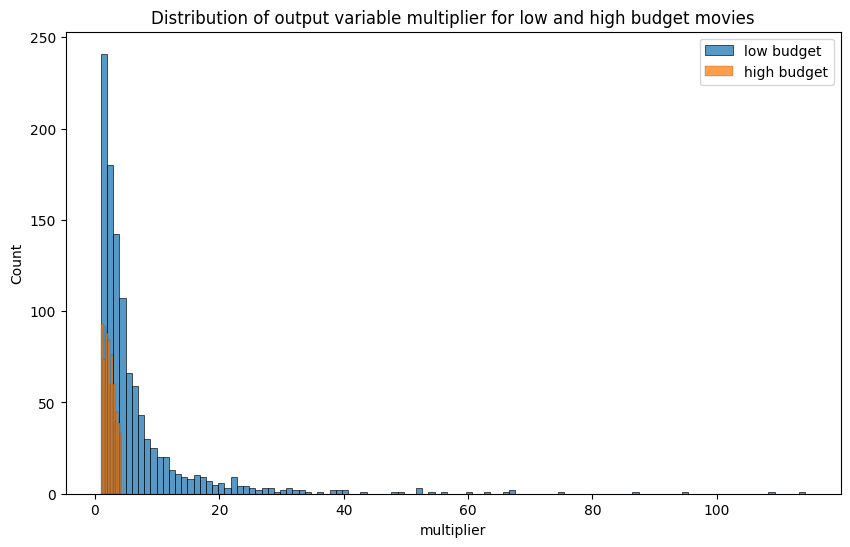

In [17]:
# plot the disitribution of output variable for low and high budget movies
plt.figure(figsize=(10, 6))
sns.histplot(output_low, label='low budget')
sns.histplot(output_high, label='high budget')
plt.title('Distribution of output variable multiplier for low and high budget movies')
plt.legend()
plt.show()

We can see from the distribution above that our `multiplier` distribution is skewed, especially for the low budget category. If the distribution of the output variable is highly skewed, applying a log transformation can help make the distribution more symmetric. This is particularly useful when dealing with models that assume a normal distribution of errors (e.g., linear regression). In regression modeling, a log transformation can linearize relationships between variables. This can be advantageous if the underlying relationship between the predictors and the output is better approximated by a linear model after the log transformation.

In [18]:
log_output_low = np.log(output_low)
log_output_high = np.log(output_high)

## Model definition

for the next parts we will use a linear regression model.

In [19]:
def compute_model(input, output, plot_summary=False, test_set=False):
    if test_set:
        X_train, X_test, y_train, y_test = train_test_split(input, output, test_size=0.15, random_state=42)
        model = sm.OLS(y_train, X_train)
        results = model.fit()
        y_pred = results.predict(X_test)
        print('The R2 score for the test set is: ', r2_score(y_test, y_pred))
    else:
        model = sm.OLS(output, input)
        results = model.fit()
    if plot_summary:
        print(results.summary())
    return results

## Model testing

In [20]:
scaled_input_high = sm.add_constant(scaled_input_high)
compute_model(scaled_input_high, log_output_high, plot_summary=True, test_set=True)

The R2 score for the test set is:  0.21874616828771054
                            OLS Regression Results                            
Dep. Variable:             multiplier   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     1.709
Date:                Thu, 21 Dec 2023   Prob (F-statistic):            0.00332
Time:                        17:34:54   Log-Likelihood:                -256.01
No. Observations:                 666   AIC:                             604.0
Df Residuals:                     620   BIC:                             811.1
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

### Best for low

In [21]:
scaled_input_low = sm.add_constant(scaled_input_low)
compute_model(scaled_input_low, log_output_low, plot_summary=True, test_set=True)

The R2 score for the test set is:  0.015393708774638859
                            OLS Regression Results                            
Dep. Variable:             multiplier   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     2.193
Date:                Thu, 21 Dec 2023   Prob (F-statistic):           1.40e-06
Time:                        17:34:55   Log-Likelihood:                -1155.4
No. Observations:                 916   AIC:                             2431.
Df Residuals:                     856   BIC:                             2720.
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

# Feature selection

### Low budgets movies

We will look at correlation between variables to see if there are some high correlated terms. 

In [22]:
# find pairs of features with correlation greater than 0.6
corr_matrix = scaled_input_low.corr().abs()
corr_matrix = corr_matrix.unstack().reset_index()
corr_matrix.columns = ['feature_1', 'feature_2', 'correlation']
corr_matrix = corr_matrix[corr_matrix['feature_1'] != corr_matrix['feature_2']]
corr_matrix = corr_matrix.sort_values(by='correlation', ascending=False)
corr_matrix = corr_matrix[corr_matrix['correlation'] > 0.6]
corr_matrix


,feature_1,feature_2,correlation
2646,onehot_production_countries_south korea,onehot_ko,1.000000
1446,onehot_ko,onehot_production_countries_south korea,1.000000
2545,onehot_production_countries_sweden,onehot_production_countries_denmark,0.960318
2725,onehot_production_countries_denmark,onehot_production_countries_sweden,0.960318
3681,onehot_production_countries_india,onehot_hi,0.874961
1341,onehot_hi,onehot_production_countries_india,0.874961
746,average_actor_exp,max_actor_exp,0.859770
866,max_actor_exp,average_actor_exp,0.859770
3068,onehot_production_countries_united_states_of_a...,onehot_en,0.781785
1148,onehot_en,onehot_production_countries_united_states_of_a...,0.781785


We can see that some of the features are highly correlated so we will include the interaction between them in the model.

In [23]:
results = compute_model(scaled_input_low, log_output_low)

# feature names
variables = results.params.index
# coefficients
coefficients = results.params.values
# p-values
p_values = results.pvalues
# standard errors
standard_errors = results.bse.values

l1, l2, l3, l4 = zip(*sorted(zip(coefficients[1:], variables[1:], standard_errors[1:], p_values[1:])))


In [24]:
def plot_predictors(l1, l2, l3, category_name = 'low'): 
    plt.figure(figsize=(12,14))
    plt.errorbar(l1, np.array(range(len(l1))), xerr= np.array(l3), linewidth = 1,
                linestyle = 'none',marker = 'o',markersize= 3,
                markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)

    plt.vlines(0,0, len(l1), linestyle = '--')
    plt.yticks(range(len(l2)),l2)
    plt.title(f'Effect of the predictors on the log of the revenue multiplier for the {category_name} budget movies')
    plt.xlabel('Coefficient')
    plt.ylabel('Predictor')
    plt.show()

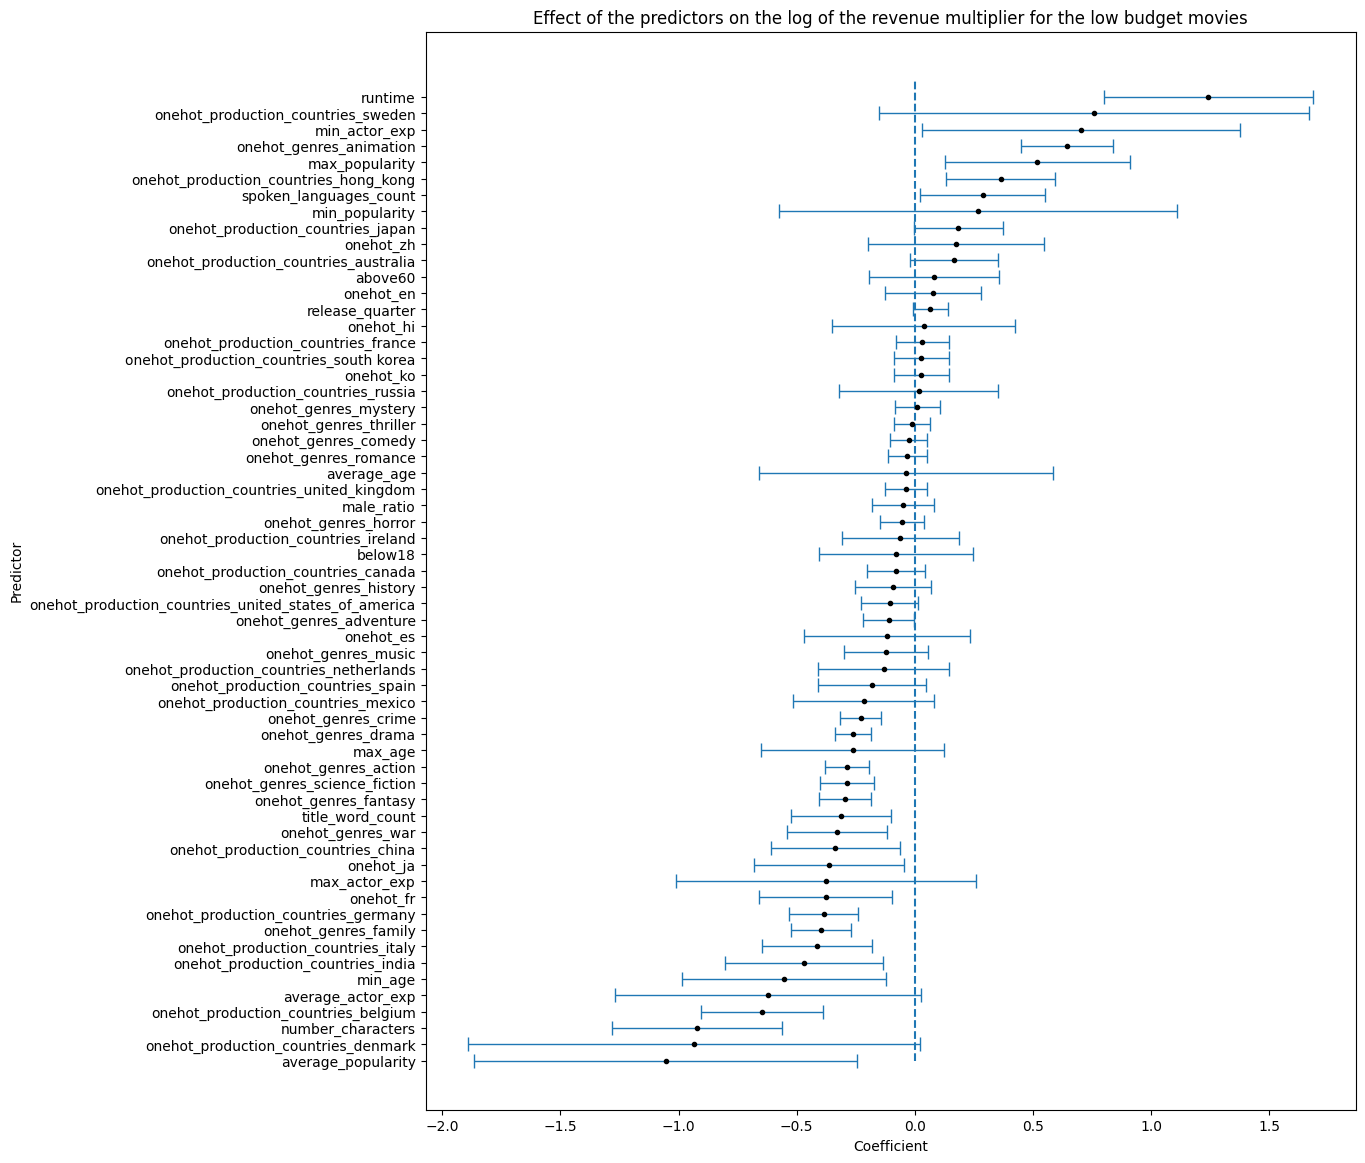

In [25]:
plot_predictors(l1, l2, l3, category_name = 'low')

We can see from the graph above that some features are not significant and the confidence interval are crossing the 0 so we are not sure if the correlation with the output is positive or negative. That is why we are choosing to remove these variables and keep only features that are significant and have positive or negative correlation with the output.

we decide to take a 68% = 1 std confidence intervals to include more variables, and be less strict of the feature selection.

In [26]:
#keep only the significant variables so values that are in 68% confidence interval (1 standard deviation)
significant_variables = variables[1:][np.abs(coefficients[1:]) > 1*standard_errors[1:]]
significant_variables

Index(['runtime', 'number_characters', 'min_age', 'average_popularity',
       'max_popularity', 'min_actor_exp', 'title_word_count',
       'spoken_languages_count', 'onehot_fr', 'onehot_ja',
       'onehot_genres_family', 'onehot_genres_fantasy',
       'onehot_genres_animation', 'onehot_genres_adventure',
       'onehot_genres_action', 'onehot_genres_war', 'onehot_genres_crime',
       'onehot_genres_science_fiction', 'onehot_genres_drama',
       'onehot_production_countries_italy',
       'onehot_production_countries_hong_kong',
       'onehot_production_countries_china',
       'onehot_production_countries_belgium',
       'onehot_production_countries_germany',
       'onehot_production_countries_india'],
      dtype='object')

In [27]:
df_l = pd.concat([scaled_input_low, log_output_low], axis=1)
df_l.columns = list(scaled_input_low.columns) + ['logmultiplier']
mod_low = smf.ols(formula= ' logmultiplier ~ runtime+ number_characters*min_age*average_popularity*max_popularity*min_actor_exp+title_word_count*spoken_languages_count*onehot_fr*onehot_ja+onehot_genres_adventure*onehot_genres_science_fiction*onehot_genres_crime*onehot_genres_drama*onehot_genres_action*onehot_genres_animation*onehot_genres_war*onehot_genres_family*onehot_genres_fantasy+onehot_production_countries_germany*onehot_production_countries_india*onehot_production_countries_italy*onehot_production_countries_china*onehot_production_countries_hong_kong*onehot_production_countries_belgium',            data=df_l)

results_regression_low = mod_low.fit()
print('R-squared:', results_regression_low.rsquared)

R-squared: 0.1706936648034113


We can see that by keeping only features that are in the 68% confidence interval and adding their interactions terms we augmented the explained variance. We will keep this model for the following parts.

In [28]:
for result in results_regression_low.params.index:
    if result not in input_low.columns:
        input_low[result] = 1
        parts = split_string(result)
        for part in parts:
            input_low[result] = input_low[result] * input_low[part]
input_low = input_low[results_regression_low.params.index]
desired_column_order = results_regression_low.params.index
# Reorder the columns 
input_low = input_low[desired_column_order]

C:\Users\jojod\AppData\Local\Temp\ipykernel_2856\2520544224.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_low[result] = 1
C:\Users\jojod\AppData\Local\Temp\ipykernel_2856\2520544224.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_low[result] = 1
C:\Users\jojod\AppData\Local\Temp\ipykernel_2856\2520544224.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(

In [29]:
variables = results_regression_low.params.index
# keep significant values only (p-value < 0.05)
significant_variables_low = variables[1:][results_regression_low.pvalues[1:] < 0.05]

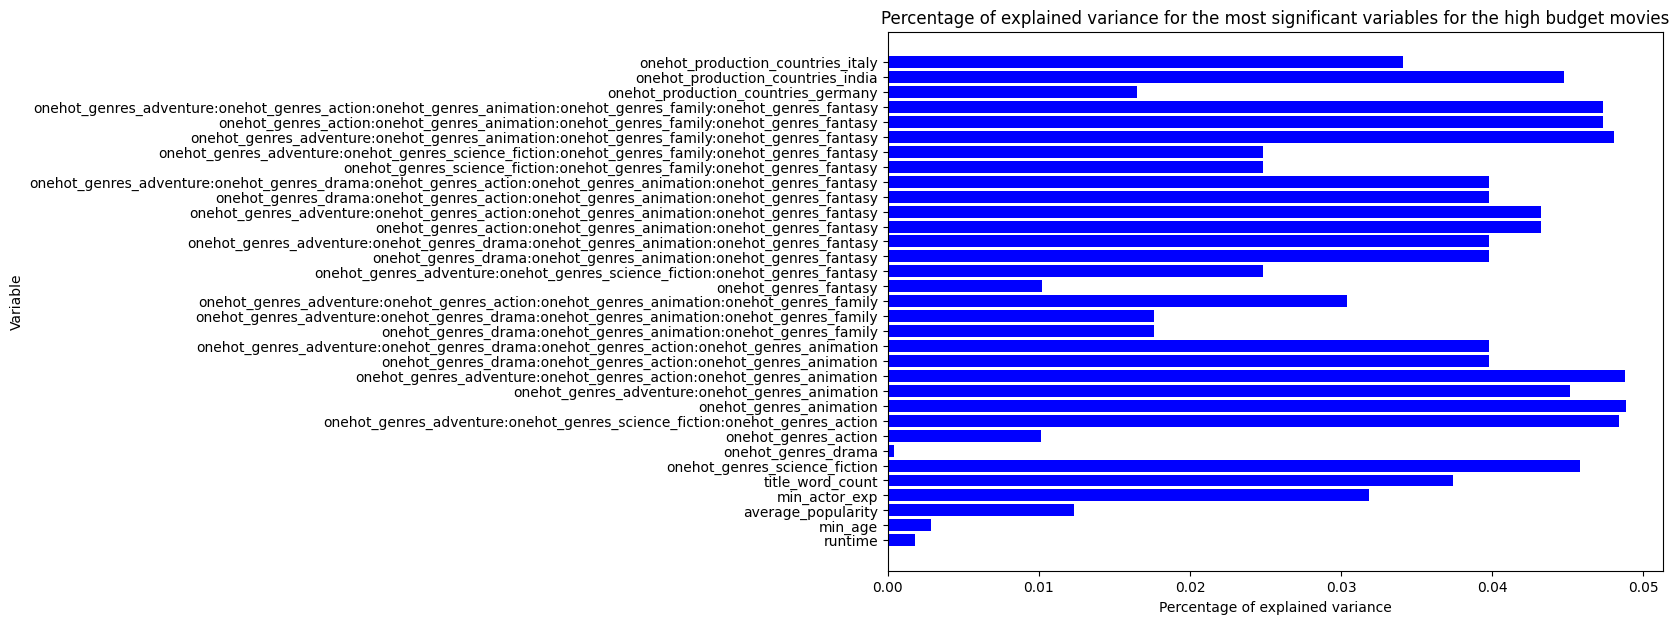

In [30]:
#plot percentage of explained variance for each variable
plt.figure(figsize=(10,7))
plt.barh(range(len(significant_variables_low)), results_regression_low.pvalues[1:][results_regression_low.pvalues[1:] < 0.05], color='blue')
plt.yticks(range(len(significant_variables_low)),significant_variables_low)
plt.title('Percentage of explained variance for the most significant variables for the high budget movies')
plt.xlabel('Percentage of explained variance')
plt.ylabel('Variable')
plt.show()

We decide to keep the most important features with interactions terms for the predictions, as these are the most significant features that explain the trend on the output.

In [31]:
input_low = input_low[significant_variables_low]
print(input_low.shape)
scaled_input_low, scaler_low = minmax_scale_input(input_low)
final_model_low = compute_model(scaled_input_low, log_output_low)

(1078, 33)


### High budget movies

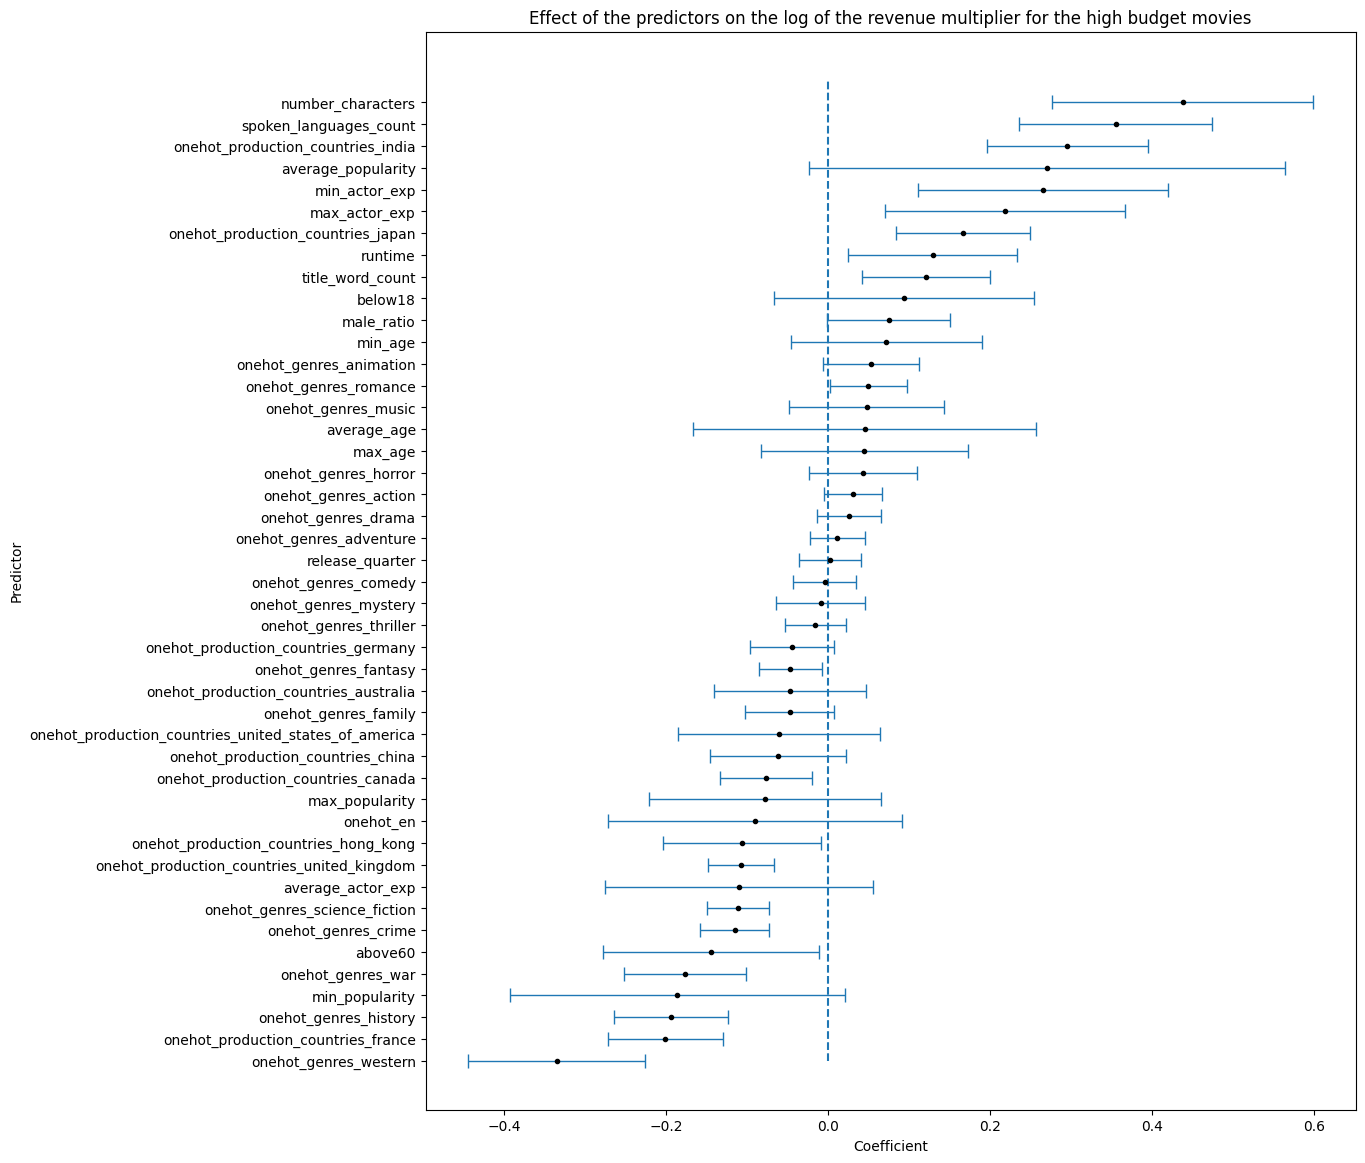

In [32]:
results = compute_model(scaled_input_high, log_output_high)

# feature names
variables = results.params.index
# coefficients
coefficients = results.params.values
# p-values
p_values = results.pvalues
# standard errors
standard_errors = results.bse.values

l1, l2, l3, l4 = zip(*sorted(zip(coefficients[1:], variables[1:], standard_errors[1:], p_values[1:])))
plot_predictors(l1, l2, l3, category_name = 'high')

In [33]:
#keep only the significant variables so values that are in 68% confidence interval (1 standard deviation)
significant_variables = variables[1:][np.abs(coefficients[1:]) > 1*standard_errors[1:]]
significant_variables

Index(['runtime', 'number_characters', 'above60', 'min_actor_exp',
       'max_actor_exp', 'title_word_count', 'spoken_languages_count',
       'onehot_genres_fantasy', 'onehot_genres_romance',
       'onehot_genres_history', 'onehot_genres_war', 'onehot_genres_crime',
       'onehot_genres_western', 'onehot_genres_science_fiction',
       'onehot_production_countries_france',
       'onehot_production_countries_canada',
       'onehot_production_countries_hong_kong',
       'onehot_production_countries_united_kingdom',
       'onehot_production_countries_japan',
       'onehot_production_countries_india'],
      dtype='object')

In [34]:
df_h = pd.concat([scaled_input_high, log_output_high], axis=1)
df_h.columns = list(scaled_input_high.columns) + ['logmultiplier']
mod_high = smf.ols(formula= ' logmultiplier ~ runtime + number_characters*above60*min_actor_exp*max_actor_exp+title_word_count*spoken_languages_count+ onehot_genres_history*onehot_genres_science_fiction*onehot_genres_crime*onehot_genres_western*onehot_genres_war*onehot_genres_romance*onehot_genres_fantasy + onehot_production_countries_united_kingdom+onehot_production_countries_japan+onehot_production_countries_india+onehot_production_countries_canada+onehot_production_countries_france+onehot_production_countries_hong_kong',            data=df_h)

results_regression_high = mod_high.fit()
print('R-squared:', results_regression_high.rsquared)

R-squared: 0.15202824565916662


we can see that by adding the interaction terms, the R-squared value increases from 0.131 to 0.152. From all these features and interactions we will keep the most significant ones for the prediction.

In [35]:
for result in results_regression_high.params.index:
    if result not in input_high.columns:
        input_high[result] = 1
        parts = split_string(result)
        for part in parts:
            input_high[result] = input_high[result] * input_high[part]
input_high = input_high[results_regression_high.params.index]
desired_column_order = results_regression_high.params.index
# Reorder the columns 
input_high = input_high[desired_column_order]

C:\Users\jojod\AppData\Local\Temp\ipykernel_2856\4215559908.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_high[result] = 1
C:\Users\jojod\AppData\Local\Temp\ipykernel_2856\4215559908.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_high[result] = 1
C:\Users\jojod\AppData\Local\Temp\ipykernel_2856\4215559908.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.conca

In [36]:
variables = results_regression_high.params.index
# keep significant values only (p-value < 0.1)
significant_variables_model_high = variables[1:][results_regression_high.pvalues[1:] < 0.1]

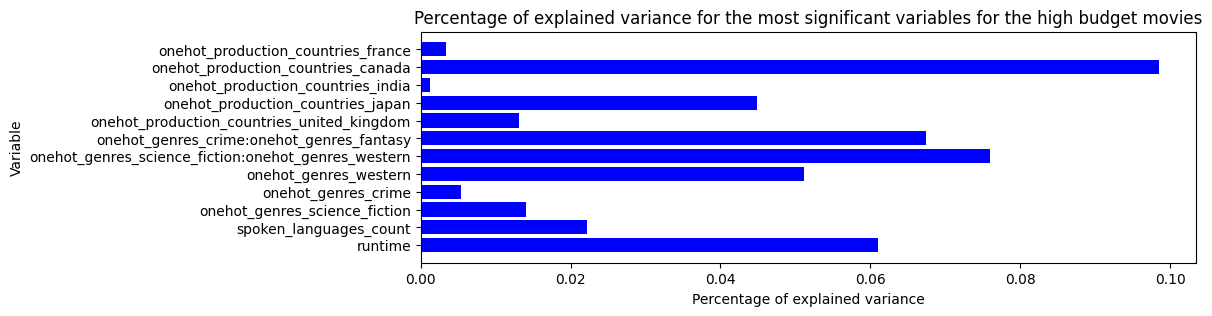

In [37]:
#plot percentage of explained variance for each variable
plt.figure(figsize=(10,3))
plt.barh(range(len(significant_variables_model_high)), results_regression_high.pvalues[1:][results_regression_high.pvalues[1:] < 0.1], color='blue')
plt.yticks(range(len(significant_variables_model_high)),significant_variables_model_high)
plt.title('Percentage of explained variance for the most significant variables for the high budget movies')
plt.xlabel('Percentage of explained variance')
plt.ylabel('Variable')
plt.show()

In [38]:
input_high = input_high[significant_variables_model_high]
scaled_input_high, scaler_high = minmax_scale_input(input_high)
final_model_high = compute_model(scaled_input_high, log_output_high)

### Classification

If we split the multipliers into 3 categories that are the low, medium and high values of the `multiplier`, we can try to perform a classification. We could then see if we arrive to predict if the multiplier will be low or high from the features.

In [39]:
class_output_low = pd.qcut(log_output_low, 3, labels=['low', 'medium', 'high'])
class_output_high = pd.qcut(log_output_high, 3, labels=['low', 'medium', 'high'])

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import r2_score, mean_squared_error


X = scaled_input_high  # Two features for simplicity
y = class_output_high # Binary classification based on a simple condition

# Split the data into training and testing sets
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=400, max_depth=20, random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Accuracy: 0.37

Classification Report:
              precision    recall  f1-score   support

        high       0.32      0.32      0.32        65
         low       0.42      0.42      0.42        69
      medium       0.37      0.37      0.37        62

    accuracy                           0.37       196
   macro avg       0.37      0.37      0.37       196
weighted avg       0.37      0.37      0.37       196



We can see from the classification above that the accuracy of 38% is quite low given that with 3 balanced classes the random chance would be arounf 33%. We can still see that the f1-score for the class of high multiplier are higher than the medium class. It signifies that the model is performing better in terms of both precision and recall for that particular class. This could mean that we are more able to identify the features that will give a high multiplier.

## Optimisation of linear Regression

We have seen in the previous part that the model that obtains the highest R-square score of and so the model that have the highest explained variance is the linear model. We know that this model can be an overfit, but it can give us some idea of the best choice to make for the producers. 
We will then use the linear model to predict the maximal `multiplier` the producers can obtain. We will also be able to give them the best features to have for their film to achieve this multiplier. 

### Model for the High budget

From the linear model we are using the coeficients estimated.

In [41]:
# these are the parameters for the model prediction
final_model_high.params

runtime                                                1.695020
spoken_languages_count                                 0.506240
onehot_genres_science_fiction                          0.116664
onehot_genres_crime                                    0.056181
onehot_genres_western                                 -0.270452
onehot_genres_science_fiction:onehot_genres_western   -0.297672
onehot_genres_crime:onehot_genres_fantasy              0.234764
onehot_production_countries_united_kingdom            -0.045118
onehot_production_countries_japan                      0.167692
onehot_production_countries_india                      0.184619
onehot_production_countries_canada                     0.047860
onehot_production_countries_france                    -0.252170
dtype: float64

### Set bounds

We have to set the bounds for the optimisation. Since we scaled the features to [0,1] the boounds are simply [0,1].

In [57]:
bounds = []
for attribute in range(len(final_model_high.params)):
    bounds.append((0, 1))

### Define Initial Guess

For the optimisation to work we have to define an initial guess. In our case we want to have the maximal `multiplier` as possible so we can use the maximal `multiplier` of our dataset as the initial guess of max multiplier.

In [58]:
def find_init_guess(input, output, name_output_column = 'multiplier'):
    '''
    Find the initial guess for the optimization algorithm
    :param dataframe: dataframe with the data
    :param name_output_column: name of the output column to maximize
    :return: initial guess of the features to maximize the output, the max value of the output and the index of the max value
    '''
    dataframe = pd.concat([input, output], axis=1)
    max = dataframe[name_output_column].max()
    idx_max = dataframe[name_output_column].idxmax()
    features = dataframe.loc[idx_max].drop(name_output_column).values
    return features, max, idx_max

In [59]:
init_features, initial_max, _ = find_init_guess(scaled_input_high, log_output_high)

### Perform Optimization

Now we perform the optimisation. We want to have the max value of the `multiplier`. The function *optimise.minimize* is a minimization function so we will simply add a - sign at the model prediction to have a maximization of the output. The model_prediction is then the sum of the coeficients founs by the linear regression model times the features.

In [60]:
from scipy import optimize

# Your trained model
def model_prediction(features):
    df_features = pd.DataFrame(features.reshape(1, -1), columns=final_model_high.params.index)
    prediction = final_model_high.predict(df_features)
    return prediction

# Objective function for optimization
def objective_function(features):
    return -model_prediction(features)  #Minimize the negative of the output


# Optimize feature values
result = optimize.minimize(objective_function, init_features, method='SLSQP', bounds=bounds)#, constraints=[integer_constraint] , options={'eps': 0.1})

# Optimized feature values
optimized_features = result.x

# Evaluate the model with optimized features
optimized_output = model_prediction(optimized_features)

In [61]:
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -3.009039870801495
       x: [ 1.000e+00  1.000e+00  1.000e+00  1.000e+00  8.298e-17
            6.720e-16  1.000e+00  5.038e-15  1.000e+00  1.000e+00
            1.000e+00  0.000e+00]
     nit: 9
     jac: [-1.695e+00 -5.062e-01 -1.167e-01 -5.618e-02  2.705e-01
            2.977e-01 -2.348e-01  4.512e-02 -1.677e-01 -1.846e-01
           -4.786e-02  2.522e-01]
    nfev: 117
    njev: 9

We can see that the optimisation terminated sucessfully.

Then we rescale to the original scale the features to have the real features values.

In [62]:
optimized_features_original_scale = scaler_high.inverse_transform([optimized_features])
init_features_original_scale = scaler_high.inverse_transform([init_features])

We apply an exponential to the log output to have the original value of multiplier.

In [63]:
optimized_output_exp = np.exp(optimized_output)
initial_max_exp = np.exp(initial_max)

We look at the difference in results between the initial guess and the optimize features.

In [64]:
print("10 first optimized features: {}".format(np.around(optimized_features_original_scale[0], 3)))
print("Optimized output: {}".format(np.around(optimized_output_exp, decimals=3)))
print("10 first initial features: {}".format(np.around(init_features_original_scale[0], decimals=3)))
print("Initial output: {}".format(initial_max_exp, decimals=3))

10 first optimized features: [191.  11.   1.   1.   0.   0.   1.   0.   1.   1.   1.   0.]
Optimized output: 0    20.268
dtype: float64
10 first initial features: [169.   1.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.]
Initial output: 4.252904278787879


The prediction of maximal multiplier is `optimized_output`.

We can do the same now for the low budgets.

### Model for the Low budgets

In [85]:
bounds = []
for column in scaled_input_low.columns:
    bounds.append((0, 1))

init_features_low, initial_max_low, _ = find_init_guess(scaled_input_low, log_output_low)

# Your trained model
def model_prediction_low(features):
    df_features = pd.DataFrame(features.reshape(1, -1), columns=final_model_low.params.index)
    prediction = final_model_low.predict(df_features)
    return prediction

# Objective function for optimization
def objective_function_low(features):
    return -model_prediction_low(features)  #Minimize the negative of the output

result_low = optimize.minimize(objective_function_low, init_features_low, method='SLSQP', bounds=bounds)#, constraints=[integer_constraint] , options={'eps': 0.1})
optimized_features_low = result_low.x
optimized_output = model_prediction_low(optimized_features)

In [86]:
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -8.453509023005765
       x: [ 1.000e+00  1.000e+00 ...  1.221e-14  8.216e-15]
     nit: 9
     jac: [-3.874e+00 -3.782e-01 ...  8.570e-01  5.229e-01]
    nfev: 306
    njev: 9

In [88]:
optimized_features_original_scale = scaler_low.inverse_transform([optimized_features_low])
init_features_original_scale = scaler_low.inverse_transform([init_features_low])

In [89]:
optimized_output_exp = np.exp(optimized_output)
initial_max_exp = np.exp(initial_max_low)

In [90]:
print("Optimized features: {}".format(np.around(optimized_features_original_scale[0], 3)))
print("Optimized output: {}".format(np.around(optimized_output_exp, decimals=3)))
print("Initial features: {}".format(np.around(init_features_original_scale, decimals=3)))
print("Initial output: {}".format(initial_max_exp, decimals=3))

Optimized features: [224.     79.    104.258   0.     13.      0.      0.      0.      1.
   1.      0.      1.      0.      0.      1.      1.      0.      0.
   0.      0.      0.      1.      1.      0.      0.      0.      0.
   1.      0.      0.      0.      0.      0.   ]
Optimized output: 0    4691.506
dtype: float64
Initial features: [[92.    24.    13.957  0.     1.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.   ]]
Initial output: 114.27488667271082


We can see that because the model overfitted our data for the low budgets, the maximize value of the output is not a possible one. Netherless, we could think that the these features can be the ones that have the highest score but we can't be sure. It will be difficult to hepl our low budget movie producers because the variance in the low bidgets movies is really big. We can't find a real trend on the features selsction and the choice is more random. 